In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import re
import warnings
from IPython.display import display
import os

In [2]:
warnings.filterwarnings('ignore') # ignore warnings.
%config IPCompleter.greedy = True # autocomplete feature.
pd.options.display.max_rows = None # set maximum rows that can be displayed in notebook.
pd.options.display.max_columns = None # set maximum columns that can be displayed in notebook.
pd.options.display.precision = 2 # set the precision of floating point numbers.
# pd.set_option('display.max_colwidth', -1) # will help to show all the text strings in the column.

In [3]:
data = pd.read_excel("candyhierarchy2017.xlsx")
data.iloc[[*range(5),*range(-5)]]

,Internal ID,Q1: GOING OUT?,Q2: GENDER,Q3: AGE,Q4: COUNTRY,"Q5: STATE, PROVINCE, COUNTY, ETC",Q6 | 100 Grand Bar,Q6 | Anonymous brown globs that come in black and orange wrappers\t(a.k.a. Mary Janes),Q6 | Any full-sized candy bar,Q6 | Black Jacks,Q6 | Bonkers (the candy),Q6 | Bonkers (the board game),Q6 | Bottle Caps,Q6 | Box'o'Raisins,Q6 | Broken glow stick,Q6 | Butterfinger,Q6 | Cadbury Creme Eggs,Q6 | Candy Corn,Q6 | Candy that is clearly just the stuff given out for free at restaurants,Q6 | Caramellos,"Q6 | Cash, or other forms of legal tender",Q6 | Chardonnay,Q6 | Chick-o-Sticks (we don’t know what that is),Q6 | Chiclets,Q6 | Coffee Crisp,Q6 | Creepy Religious comics/Chick Tracts,Q6 | Dental paraphenalia,Q6 | Dots,Q6 | Dove Bars,Q6 | Fuzzy Peaches,Q6 | Generic Brand Acetaminophen,Q6 | Glow sticks,Q6 | Goo Goo Clusters,Q6 | Good N' Plenty,Q6 | Gum from baseball cards,Q6 | Gummy Bears straight up,Q6 | Hard Candy,Q6 | Healthy Fruit,Q6 | Heath Bar,Q6 | Hershey's Dark Chocolate,Q6 | Hershey’s Milk Chocolate,Q6 | Hershey's Kisses,Q6 | Hugs (actual physical hugs),Q6 | Jolly Rancher (bad flavor),Q6 | Jolly Ranchers (good flavor),Q6 | JoyJoy (Mit Iodine!),Q6 | Junior Mints,Q6 | Senior Mints,Q6 | Kale smoothie,Q6 | Kinder Happy Hippo,Q6 | Kit Kat,Q6 | LaffyTaffy,Q6 | LemonHeads,Q6 | Licorice (not black),Q6 | Licorice (yes black),Q6 | Lindt Truffle,Q6 | Lollipops,Q6 | Mars,Q6 | Maynards,Q6 | Mike and Ike,Q6 | Milk Duds,Q6 | Milky Way,Q6 | Regular M&Ms,Q6 | Peanut M&M’s,Q6 | Blue M&M's,Q6 | Red M&M's,Q6 | Green Party M&M's,Q6 | Independent M&M's,Q6 | Abstained from M&M'ing.,Q6 | Minibags of chips,Q6 | Mint Kisses,Q6 | Mint Juleps,Q6 | Mr. Goodbar,Q6 | Necco Wafers,Q6 | Nerds,Q6 | Nestle Crunch,Q6 | Now'n'Laters,Q6 | Peeps,Q6 | Pencils,Q6 | Pixy Stix,Q6 | Real Housewives of Orange County Season 9 Blue-Ray,Q6 | Reese’s Peanut Butter Cups,Q6 | Reese's Pieces,Q6 | Reggie Jackson Bar,Q6 | Rolos,Q6 | Sandwich-sized bags filled with BooBerry Crunch,Q6 | Skittles,Q6 | Smarties (American),Q6 | Smarties (Commonwealth),Q6 | Snickers,Q6 | Sourpatch Kids (i.e. abominations of nature),Q6 | Spotted Dick,Q6 | Starburst,Q6 | Sweet Tarts,Q6 | Swedish Fish,Q6 | Sweetums (a friend to diabetes),Q6 | Take 5,Q6 | Tic Tacs,Q6 | Those odd marshmallow circus peanut things,Q6 | Three Musketeers,Q6 | Tolberone something or other,Q6 | Trail Mix,Q6 | Twix,"Q6 | Vials of pure high fructose corn syrup, for main-lining into your vein",Q6 | Vicodin,Q6 | Whatchamacallit Bars,Q6 | White Bread,Q6 | Whole Wheat anything,Q6 | York Peppermint Patties,Q7: JOY OTHER,Q8: DESPAIR OTHER,Q9: OTHER COMMENTS,Q10: DRESS,Unnamed: 113,Q11: DAY,Q12: MEDIA [Daily Dish],Q12: MEDIA [Science],Q12: MEDIA [ESPN],Q12: MEDIA [Yahoo],"Click Coordinates (x, y)"
0,90258773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90272821,No,Male,44,USA,NM,MEH,DESPAIR,JOY,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,MEH,DESPAIR,MEH,JOY,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,DESPAIR,MEH,MEH,DESPAIR,MEH,JOY,JOY,MEH,DESPAIR,DESPAIR,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,DESPAIR,MEH,MEH,JOY,MEH,DESPAIR,DESPAIR,DESPAIR,MEH,MEH,JOY,JOY,MEH,JOY,JOY,JOY,JOY,DESPAIR,DESPAIR,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,JOY,DESPAIR,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,DESPAIR,DESPAIR,MEH,DESPAIR,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,JOY,DESPAIR,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,Mounds,NaN,Bottom line is Twix is really the only candy w...,White and gold,NaN,Sunday,Na

In [4]:
data.shape

(2460, 120)

In [5]:
data.dtypes.iloc[[*range(10), *range(-10, 0)]]

Internal ID                                                                                 int64
Q1: GOING OUT?                                                                             object
Q2: GENDER                                                                                 object
Q3: AGE                                                                                    object
Q4: COUNTRY                                                                                object
Q5: STATE, PROVINCE, COUNTY, ETC                                                           object
Q6 | 100 Grand Bar                                                                         object
Q6 | Anonymous brown globs that come in black and orange wrappers\t(a.k.a. Mary Janes)     object
Q6 | Any full-sized candy bar                                                              object
Q6 | Black Jacks                                                                           object
Q8: DESPAIR OTHER   

>we take the first ten and the last ten columns from the data frame to cover the the most data types 

In [6]:
def miss_percent(data_frame):
    
    total_miss = data_frame.isnull().sum().sort_values(ascending=False)[0:10]
    total_miss = total_miss[total_miss.values !=0]
    percent = np.round(total_miss.values*100.00/len(data_frame), 2)
    df = pd.DataFrame(total_miss, columns=['Number Of Missing Values'])
    return(df.assign(percentage_of_missing_values=percent))#we add anew column that have the percentage of missing values

In [7]:
miss_percent(data)

,Number Of Missing Values,percentage_of_missing_values
Unnamed: 113,2451,99.63
Q12: MEDIA [Yahoo],2393,97.28
Q12: MEDIA [Daily Dish],2375,96.54
Q12: MEDIA [ESPN],2361,95.98
Q9: OTHER COMMENTS,2074,84.31
Q8: DESPAIR OTHER,1743,70.85
Q7: JOY OTHER,1549,62.97
Q12: MEDIA [Science],1098,44.63
Q6 | JoyJoy (Mit Iodine!),1026,41.71
Q6 | Maynards,1024,41.63


>we notice that media columns most of their values are missing but we can handle that by joining these columns together

In [8]:
data.duplicated().sum()    #so there is no duplicated values

0

In [9]:
#drop the columns that have high rate of missing values above[70%] percentage of  missing mising values
data.drop(["Unnamed: 113","Q9: OTHER COMMENTS","Q8: DESPAIR OTHER","Q7: JOY OTHER","Click Coordinates (x, y)",],axis=1,inplace=True)

In [10]:
#drop useless columns 
data.drop(["Internal ID"],axis=1,inplace=True)

<h1 align='left'><font size="4" color='brown'>these are the first five columns we are gonna clean after Q6 columns</font> 

In [11]:
def miss_percent(data_frame):
    
    total_miss = data_frame.isnull().sum().sort_values(ascending=True)[0:5]
    total_miss = total_miss[total_miss.values !=0]
    percent = np.round(total_miss.values*100.00/len(data_frame), 2)
    df = pd.DataFrame(total_miss, columns=['Number Of Missing Values'])
    return(df.assign(percentage_of_missing_values=percent))#we add anew column that have the percentage of missing values

In [12]:
miss_percent(data)

,Number Of Missing Values,percentage_of_missing_values
Q2: GENDER,41,1.67
Q4: COUNTRY,64,2.60
Q3: AGE,84,3.41
"Q5: STATE, PROVINCE, COUNTY, ETC",100,4.07
Q1: GOING OUT?,110,4.47


## NOTE:-
- There are 2460 rows and 120 columns 
- There are two useless columns:
    - "Unnamed: 113".
    - "Click Coordinates (x, y)"
- some features need aspecial analysis and may be useful we have to analyise each observation to know which considred NaNs:
    - Q9: OTHER COMMENTS 
    - Q8: DESPAIR OTHER
    - Q7: JOY OTHER
-so am gonna drop these columnsand have alot of missing values and useless


In [13]:
missing_Q1=data[data["Q1: GOING OUT?"].isna()]
np.round(missing_Q1.isna().sum()*100.00/len(missing_Q1), 2)

Q1: GOING OUT?                                                                            100.00
Q2: GENDER                                                                                 24.55
Q3: AGE                                                                                    24.55
Q4: COUNTRY                                                                                24.55
Q5: STATE, PROVINCE, COUNTY, ETC                                                           23.64
Q6 | 100 Grand Bar                                                                         44.55
Q6 | Anonymous brown globs that come in black and orange wrappers\t(a.k.a. Mary Janes)     47.27
Q6 | Any full-sized candy bar                                                              42.73
Q6 | Black Jacks                                                                           50.00
Q6 | Bonkers (the candy)                                                                   54.55
Q6 | Bonkers (the board game) 

>so as we see that the people who dont specify they go out they also ignore the almost survey (they get bored or something like that start from the Q6(survey)the missing percentage getting increasd so i will remove the people who didnt pay attention to the survey

In [14]:
data.dropna(subset=data.iloc[6:].columns, how='all', inplace=True)

<h1 align='left'><font size="4" color='brown'>to make analysis easier we make some processes</font> 

In [15]:
data.rename(columns = {'Q1: GOING OUT?' : 'Going Out?',
                          'Q2: GENDER' : 'Gender',
                          'Q3: AGE': 'Age',
                          'Q4: COUNTRY' : 'Country',
                          'Q5: STATE, PROVINCE, COUNTY, ETC' : 'Area',
                          'Q10: DRESS' : 'Dress',
                          'Q11: DAY': 'Day',
                          'Q12: MEDIA [Daily Dish]' : 'DailyDish',
                          'Q12: MEDIA [Science]': 'Science',
                          'Q12: MEDIA [ESPN]' : 'ESPN',
                          'Q12: MEDIA [Yahoo]': 'Yahoo'}, inplace=True)

In [16]:
data.dropna(axis=0, how="all", subset=data.columns[1:], inplace=True)

>so we drop the rows that all values are missing values

Before cleaning the Q6 columns we notice something that the people

<h1 align='left'><font color='brown'>Cleaning Columns Q6:-</font> 

In [17]:
def miss_percent(data_frame):
    
    total_miss = data_frame.isnull().sum().sort_values(ascending=True)[5:-6]
    total_miss = total_miss[total_miss.values !=0]
    percent = np.round(total_miss.values*100.00/len(data_frame), 2)
    df = pd.DataFrame(total_miss, columns=['Number Of Missing Values'])
    return(df.assign(percentage_of_missing_values=percent))#we add anew column that have the percentage of missing values

In [18]:
miss_percent(data)

,Number Of Missing Values,percentage_of_missing_values
Q6 | Peanut M&M’s,645,26.50
Q6 | Any full-sized candy bar,646,26.54
Q6 | Hershey’s Milk Chocolate,646,26.54
Q6 | Hershey's Dark Chocolate,647,26.58
Q6 | Kit Kat,648,26.62
Q6 | Regular M&Ms,649,26.66
Q6 | Candy Corn,652,26.79
Q6 | Hershey's Kisses,652,26.79
Q6 | Reese’s Peanut Butter Cups,653,26.83
"Q6 | Cash, or other forms of legal tender",654,26.87


>so as we notice that the [Q6 columns ]has the same values and have 40% missing values so we are gonna impute the missing values with mode we do this bc the missing values from 27.00 to 48.00

In [19]:
for i in data.iloc[:,5:-6].columns:
    data[i]=data[i].fillna(data[i].mode()[0])

> so that the percentage of missing values of <strong><font color='brown'>Q6_columns</font></strong>  from 27% to 30% so there are another ways to handle but am gonna impute the rows that have the missing values with the most frequenced value in each feature

In [20]:
data.iloc[:,5:-6].isna().sum().sum()

0

In [21]:
data.columns=data.columns.str.replace("Q6 \| ",'')
data.head(1)

,Going Out?,Gender,Age,Country,Area,100 Grand Bar,Anonymous brown globs that come in black and orange wrappers\t(a.k.a. Mary Janes),Any full-sized candy bar,Black Jacks,Bonkers (the candy),Bonkers (the board game),Bottle Caps,Box'o'Raisins,Broken glow stick,Butterfinger,Cadbury Creme Eggs,Candy Corn,Candy that is clearly just the stuff given out for free at restaurants,Caramellos,"Cash, or other forms of legal tender",Chardonnay,Chick-o-Sticks (we don’t know what that is),Chiclets,Coffee Crisp,Creepy Religious comics/Chick Tracts,Dental paraphenalia,Dots,Dove Bars,Fuzzy Peaches,Generic Brand Acetaminophen,Glow sticks,Goo Goo Clusters,Good N' Plenty,Gum from baseball cards,Gummy Bears straight up,Hard Candy,Healthy Fruit,Heath Bar,Hershey's Dark Chocolate,Hershey’s Milk Chocolate,Hershey's Kisses,Hugs (actual physical hugs),Jolly Rancher (bad flavor),Jolly Ranchers (good flavor),JoyJoy (Mit Iodine!),Junior Mints,Senior Mints,Kale smoothie,Kinder Happy Hippo,Kit Kat,LaffyTaffy,LemonHeads,Licorice (not black),Licorice (yes black),Lindt Truffle,Lollipops,Mars,Maynards,Mike and Ike,Milk Duds,Milky Way,Regular M&Ms,Peanut M&M’s,Blue M&M's,Red M&M's,Green Party M&M's,Independent M&M's,Abstained from M&M'ing.,Minibags of chips,Mint Kisses,Mint Juleps,Mr. Goodbar,Necco Wafers,Nerds,Nestle Crunch,Now'n'Laters,Peeps,Pencils,Pixy Stix,Real Housewives of Orange County Season 9 Blue-Ray,Reese’s Peanut Butter Cups,Reese's Pieces,Reggie Jackson Bar,Rolos,Sandwich-sized bags filled with BooBerry Crunch,Skittles,Smarties (American),Smarties (Commonwealth),Snickers,Sourpatch Kids (i.e. abominations of nature),Spotted Dick,Starburst,Sweet Tarts,Swedish Fish,Sweetums (a friend to diabetes),Take 5,Tic Tacs,Those odd marshmallow circus peanut things,Three Musketeers,Tolberone something or other,Trail Mix,Twix,"Vials of pure high fructose corn syrup, for main-lining into your vein",Vicodin,Whatchamacallit Bars,White Bread,Whole Wheat anything,York Peppermint Patties,Dress,Day,DailyDish,Science,ESPN,Yahoo
1,No,Male,44,USA,NM,MEH,DESPAIR,JOY,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,MEH,DESPAIR,MEH,JOY,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,DESPAIR,MEH,MEH,DESPAIR,MEH,JOY,JOY,MEH,DESPAIR,DESPAIR,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,DESPAIR,MEH,MEH,JOY,MEH,DESPAIR,DESPAIR,DESPAIR,MEH,MEH,JOY,JOY,MEH,JOY,JOY,JOY,JOY,DESPAIR,DESPAIR,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,JOY,DESPAIR,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,DESPAIR,DESPAIR,MEH,DESPAIR,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,JOY,DESPAIR,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,White and gold,Sunday,NaN,1.0,NaN,NaN


>so we clean the columns from the fifth column to the lastb columns expect the last six columns so we are gonna clean them 

<h1 align='left'><font size="4 " color='brown'> Cleaning the first five columns:-</font> 

<h1 align='left'><font size="4" color='brown'>cleaning Dress column</font> 

In [22]:
data['Dress'].unique()

array(['White and gold', nan, 'Blue and black'], dtype=object)

In [23]:
data["Dress"].value_counts()

White and gold    1081
Blue and black     635
Name: Dress, dtype: int64

In [24]:
data['Dress']=data['Dress'].fillna(data['Dress'].mode()[0])

<h1 align='left'><font size="4" color='brown'>cleaning Going Out?</font> 

In [25]:
data['Going Out?'].unique()

array(['No', nan, 'Yes'], dtype=object)

In [26]:
data["Going Out?"].value_counts() # so there is abig difference in mode so we are gonna impute the missing values with mode

No     2034
Yes     311
Name: Going Out?, dtype: int64

In [27]:
data['Going Out?']=data['Going Out?'].fillna("other")

<h1 align='left'><font size="4" color='brown'>cleaning Area</font> 

In [28]:
data['Area'].nunique() 

511

>as we see it has a lotof nununique values so so it gonna be a useless column and i willnot perfit from it

In [29]:
data.drop(["Area"],axis=1,inplace=True)

<h1 align='left'><font size="4" color='brown'>cleaning Gender</font> 

In [30]:
data['Gender'].unique()

array(['Male', 'Female', "I'd rather not say", nan, 'Other'], dtype=object)

In [31]:
data["Gender"].isnull().sum()

15

In [32]:
data['Gender']=data['Gender'].fillna("i'd rather not say")

<h1 align='left'><font size="4" color='brown'>cleaning Age</font> 

In [33]:
data["Age"].unique()

array([44, 49, 40, 23, nan, 53, 33, 43, 56, 64, 37, 59, 48, 54, 36, 45,
       25, 34, 35, 38, 58, 50, 47, 16, 52, 63, 65, 41, 27, 31, 61, 46, 42,
       62, 29, 39, 32, 28, 69, 67, 30, 22, 26, 51, 70, 24, 18, 19,
       'Old enough', 57, 60, 66, 12, 'Many', 55, 72, '?', 21, 11, 'no', 9,
       68, 20, 6, 10, 71, 90, 13, '45-55', 312, 99, 7, 'hahahahaha', 88,
       39.4, 74, 102, 'older than dirt', 17, 15, 8, 75, '5u', 'Enough',
       'See question 2', '24-50', 14, 'Over 50', 100, 76, 1000,
       'sixty-nine', '46 Halloweens.', 'ancient', 77, 'OLD', 'old', 73,
       70.5, 1, 'MY NAME JEFF', 4, '59 on the day after Halloween',
       'old enough', 'your mom',
       'I can remember when Java was a cool new language', '60+'],
      dtype=object)

>so it has a useless values so we are gonna change the data type and also impute the missing values and also replace these useless values with nan values 

In [34]:
data["Age"]=pd.to_numeric(data["Age"],errors="coerce") 

In [35]:
data["Age"].unique()

array([  44. ,   49. ,   40. ,   23. ,    nan,   53. ,   33. ,   43. ,
         56. ,   64. ,   37. ,   59. ,   48. ,   54. ,   36. ,   45. ,
         25. ,   34. ,   35. ,   38. ,   58. ,   50. ,   47. ,   16. ,
         52. ,   63. ,   65. ,   41. ,   27. ,   31. ,   61. ,   46. ,
         42. ,   62. ,   29. ,   39. ,   32. ,   28. ,   69. ,   67. ,
         30. ,   22. ,   26. ,   51. ,   70. ,   24. ,   18. ,   19. ,
         57. ,   60. ,   66. ,   12. ,   55. ,   72. ,   21. ,   11. ,
          9. ,   68. ,   20. ,    6. ,   10. ,   71. ,   90. ,   13. ,
        312. ,   99. ,    7. ,   88. ,   39.4,   74. ,  102. ,   17. ,
         15. ,    8. ,   75. ,   14. ,  100. ,   76. , 1000. ,   77. ,
         73. ,   70.5,    1. ,    4. ])

In [36]:
data.loc[data['Age']>80,"Age"]=np.nan

Text(0.5, 1.0, 'age outlairs')

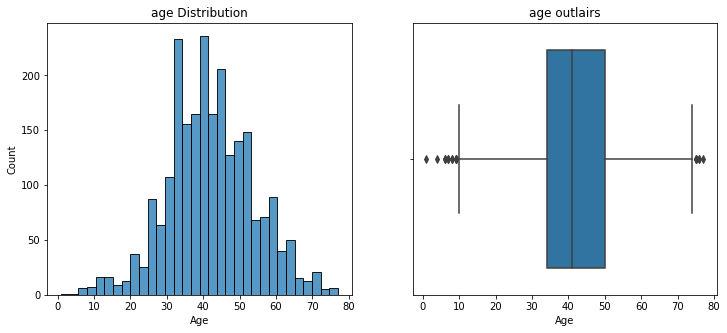

In [37]:
 #plt.figure(figsize=(10,5))
fig, ax=plt.subplots(1,2,figsize=(12,5))
sns.histplot(data=data, x='Age', ax=ax[0])
ax[0].set_title('age Distribution')
sns.boxplot(data=data, x='Age', ax=ax[1])
ax[1].set_title('age outlairs')
    

>as we see that there are outlairs here so we are gonna impute wih mdian or trimmed mean or weighted mean or median as you want but also as we see from the distrpution that slightly skewed so the mean not have abig difference than median 

In [38]:
age_rate=data.groupby(["Gender"])["Age"].median()
Age = pd.DataFrame(age_rate)
Age

,Age
Gender,
Female,40.0
I'd rather not say,40.0
Male,42.0
Other,33.0
i'd rather not say,45.0


In [39]:
for i in Age.index:
    data.loc[data["Gender"]==i,"Age"]=data.loc[data["Gender"]==i,"Age"].fillna(Age.loc[i])

In [40]:
data=data[data["Age"]<90]
data["Age"]=data["Age"].astype('int')

In [41]:
data.dtypes.iloc[[*range(10), *range(-10, 0)]]

Going Out?                                                                            object
Gender                                                                                object
Age                                                                                    int32
Country                                                                               object
100 Grand Bar                                                                         object
Anonymous brown globs that come in black and orange wrappers\t(a.k.a. Mary Janes)     object
Any full-sized candy bar                                                              object
Black Jacks                                                                           object
Bonkers (the candy)                                                                   object
Bonkers (the board game)                                                              object
Whatchamacallit Bars                                                  

<h1 align='left'><font size="4" color='brown'>cleaning Day</font> 

In [42]:
data['Day'].unique()

array(['Sunday', nan, 'Friday'], dtype=object)

In [43]:
data['Day'].value_counts()

Friday    1056
Sunday     623
Name: Day, dtype: int64

In [44]:
data['Day'].fillna(data['Day'].mode()[0], inplace=True)

<h1 align='left'><font size="4" color='brown'>cleaning Country</font> 

In [45]:
data['Country'] = data['Country'].str.strip().str.lower()

In [46]:
data['Country'].unique()

array(['usa', 'us', 'canada', nan, 'murica', 'united states', 'uk',
       'united kingdom', 'united staes', 'united states of america',
       'uae', 'england', 'mexico', 'u.s.a.', 'usausausa', 'america',
       'france', 'finland', 'unhinged states', 'us of a', 'unites states',
       'the united states', 'north carolina', 'unied states',
       'netherlands', 'germany', 'europe', 'u s', 'u.s.', 'u.k.',
       'costa rica', 'the united states of america', 'unite states',
       'cascadia', 'australia', 'greece', 'usa? hard to tell anymore..',
       "'merica", 'usas', 'pittsburgh', 'united state', 'can', 'canae',
       'new york', 'trumpistan', 'ireland', 'united sates', 'korea',
       'california', 'japan', 'south africa',
       'i pretend to be from canada, but i am really from the united states.',
       'iceland', 'canada`', 'scotland', 'denmark', 'united stated',
       'switzerland', 'ud', 'south korea', 'new jersey', 'indonesia',
       'united ststes', 'the netherlands', '

>as we see that there alot of values have the same meaning but in different forms so we have to get rid of redudancy values and union it

In [47]:
countries = pd.Series(['usa', 'united states of america','america','united kingdom england', 'hong kong', 'china', 'sweden', 'spain',
                       'ireland', 'taiwan', 'singapore', 'netherlands', 
                       'indonesia', 'south korea', 'switzerland', 'denmark', 'scotland', 'canada', 'iceland', 'south africa', 
                       'japan', 'greece', 'costa rica', 'germany', 'finland', 'france', 'mexico'])

for country in countries:
    matches = process.extract(country, data['Country'], limit = data.shape[0])
    for potential_match in matches:
        if potential_match[1] >= 80:
            data.loc[data['Country'] == potential_match[0], 'Country'] = country
            
data['Country'].unique()

array(['usa', 'canada', nan, 'murica', 'america', 'uk', 'uae',
       'united kingdom england', 'mexico', 'u.s.a.', 'france', 'finland',
       'north carolina', 'netherlands', 'germany', 'europe', 'u.k.',
       'costa rica', 'cascadia', 'australia', 'greece',
       'usa? hard to tell anymore..', 'pittsburgh', 'canae', 'new york',
       'trumpistan', 'iceland', 'south korea', 'california', 'japan',
       'south africa', 'scotland', 'denmark', 'switzerland', 'ud',
       'new jersey', 'indonesia', 'endland', 'murrika',
       'soviet canuckistan', 'singapore', 'china', 'taiwan', 'hong kong',
       'spain', 'sweden', 'narnia', 'u s a', "i don't know anymore"],
      dtype=object)

In [48]:
data['Country'].value_counts()

usa                            1288
america                         715
canada                          221
uk                               18
germany                          10
u.s.a.                            8
netherlands                       7
australia                         7
japan                             5
scotland                          5
iceland                           5
mexico                            4
switzerland                       3
france                            3
denmark                           2
china                             2
south korea                       2
hong kong                         2
sweden                            2
finland                           1
singapore                         1
murica                            1
uae                               1
south africa                      1
california                        1
new york                          1
pittsburgh                        1
indonesia                   

In [49]:
data['Country'] = data['Country'].replace({'murica':'usa', 'united states of america':'usa','america':'usa', 'u.s.a.':'usa',
'north carolina':'usa', 'usa? hard to tell anymore..':'usa', 'pittsburgh':'usa', 'new york':'usa', 'trumpistan':'usa',
          'california':'usa', 'ud':'usa', 'new jersey':'usa', 'endland':'uk', 'soviet canuckistan':'canada',
           'u s a':'usa', 'united kingdom england':'uk', 'u.k.':'uk', 'cascadia':'usa'})

In [50]:
data[~data["Country"].isin(['usa', 'uk','canada'])]='unavailable'

In [51]:
data["Country"].value_counts()

usa            2022
canada          222
unavailable      78
uk               21
Name: Country, dtype: int64

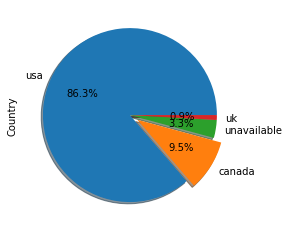

In [52]:
explode=(0,0.1,0,0)
data["Country"].value_counts().plot(kind="pie",autopct="%1.1f%%",shadow=True,explode=explode)
plt.show()

In [53]:
data.head(1)

,Going Out?,Gender,Age,Country,100 Grand Bar,Anonymous brown globs that come in black and orange wrappers\t(a.k.a. Mary Janes),Any full-sized candy bar,Black Jacks,Bonkers (the candy),Bonkers (the board game),Bottle Caps,Box'o'Raisins,Broken glow stick,Butterfinger,Cadbury Creme Eggs,Candy Corn,Candy that is clearly just the stuff given out for free at restaurants,Caramellos,"Cash, or other forms of legal tender",Chardonnay,Chick-o-Sticks (we don’t know what that is),Chiclets,Coffee Crisp,Creepy Religious comics/Chick Tracts,Dental paraphenalia,Dots,Dove Bars,Fuzzy Peaches,Generic Brand Acetaminophen,Glow sticks,Goo Goo Clusters,Good N' Plenty,Gum from baseball cards,Gummy Bears straight up,Hard Candy,Healthy Fruit,Heath Bar,Hershey's Dark Chocolate,Hershey’s Milk Chocolate,Hershey's Kisses,Hugs (actual physical hugs),Jolly Rancher (bad flavor),Jolly Ranchers (good flavor),JoyJoy (Mit Iodine!),Junior Mints,Senior Mints,Kale smoothie,Kinder Happy Hippo,Kit Kat,LaffyTaffy,LemonHeads,Licorice (not black),Licorice (yes black),Lindt Truffle,Lollipops,Mars,Maynards,Mike and Ike,Milk Duds,Milky Way,Regular M&Ms,Peanut M&M’s,Blue M&M's,Red M&M's,Green Party M&M's,Independent M&M's,Abstained from M&M'ing.,Minibags of chips,Mint Kisses,Mint Juleps,Mr. Goodbar,Necco Wafers,Nerds,Nestle Crunch,Now'n'Laters,Peeps,Pencils,Pixy Stix,Real Housewives of Orange County Season 9 Blue-Ray,Reese’s Peanut Butter Cups,Reese's Pieces,Reggie Jackson Bar,Rolos,Sandwich-sized bags filled with BooBerry Crunch,Skittles,Smarties (American),Smarties (Commonwealth),Snickers,Sourpatch Kids (i.e. abominations of nature),Spotted Dick,Starburst,Sweet Tarts,Swedish Fish,Sweetums (a friend to diabetes),Take 5,Tic Tacs,Those odd marshmallow circus peanut things,Three Musketeers,Tolberone something or other,Trail Mix,Twix,"Vials of pure high fructose corn syrup, for main-lining into your vein",Vicodin,Whatchamacallit Bars,White Bread,Whole Wheat anything,York Peppermint Patties,Dress,Day,DailyDish,Science,ESPN,Yahoo
1,No,Male,44,usa,MEH,DESPAIR,JOY,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,MEH,DESPAIR,MEH,JOY,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,DESPAIR,MEH,MEH,DESPAIR,MEH,JOY,JOY,MEH,DESPAIR,DESPAIR,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,DESPAIR,MEH,MEH,JOY,MEH,DESPAIR,DESPAIR,DESPAIR,MEH,MEH,JOY,JOY,MEH,JOY,JOY,JOY,JOY,DESPAIR,DESPAIR,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,JOY,DESPAIR,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,MEH,DESPAIR,DESPAIR,MEH,DESPAIR,MEH,DESPAIR,DESPAIR,DESPAIR,DESPAIR,JOY,JOY,DESPAIR,JOY,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,DESPAIR,White and gold,Sunday,NaN,1.0,NaN,NaN


<h1 align='left'><font size="4" color='brown'>cleaning media</font> 

In [54]:
media=data.iloc[:5,-4:]
media

,DailyDish,Science,ESPN,Yahoo
1,NaN,1.0,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN
4,NaN,1.0,NaN,NaN
6,NaN,NaN,NaN,NaN


In [55]:
for i in media.columns:
    media.loc[media[i] == 1.0, i] = i

In [57]:
data['total_media']= media.sum(axis=1)
#then am gonna drop the old columns
data.drop(columns=media, inplace=True)

In [58]:
for i in data.columns:
    if i == 'Age':
        continue
    
    data=data.astype({i:'category'},errors='raise')

-[LinkedIn](https://www.linkedin.com/in/rania-hossam55)